In [1]:
%matplotlib notebook
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
%config InlineBackend.figure_format = 'svg'

from matplotlib.pyplot import*
from numpy import zeros, array,log,dot,sqrt,conjugate,real,imag,arange,transpose
from scipy.sparse.linalg import eigs
from scipy.linalg import eigh,eig,expm
from scipy.optimize import minimize
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from copy import deepcopy
from time import time
import pickle
import json
from scipy.sparse.linalg import eigs

# The Spin $1/2$

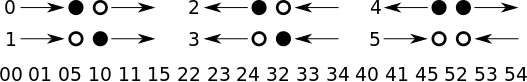

## Basic State Building, Hamiltonian and Observables

Functions for basic vertex operations of the vertices

In [2]:
#Array storing values of the electric field associated with the different vertices
ef=zeros(6)+1
ef[2]=-1;ef[3]=-1;ef[5]=-1

#Array storing values of the charge associated with the different vertices
ch=zeros(6)
ch[4]=1;ch[5]=-1

#Given a state, returns the list of valid states with one more site
def add_site(st):
    n=st[-1]
    lst=[]
    if n==0:
        lst=[st+[0],st+[1],st+[5]]
    elif n==1:
        lst=[st+[0],st+[1],st+[5]]
    elif n==2:
        lst=[st+[2],st+[3],st+[4]]  
    elif n==3:
        lst=[st+[2],st+[3],st+[4]]
    elif n==4:
        lst=[st+[0],st+[1],st+[5]]
    else:
        lst=[st+[2],st+[3],st+[4]]
    return lst

#Returns the possible single vertex transitions
def transitions_single(n):
    if n<2:
        return [1-n] 
    elif n<4:
        return [5-n]
    return []

#Returns the possible two vertex transitions
def transitions_pair(p):
    if p==[1,1]:
        return [5,4]
    elif p==[2,2]:
        return [4,5]
    elif p==[1,5]:
        return [5,2]
    elif p==[1,1]:
        return [5,4]
    elif p==[2,2]:
        return [4,5]
    elif p==[2,4]:
        return [4,1]
    elif p==[4,1]:
        return [2,4]
    elif p==[4,5]:
        return [2,2]
    elif p==[5,2]:
        return [1,5]
    elif p==[5,4]:
        return [1,1]
    return []

Building a basis, constructing the Hamiltonian and construction of the Hamiltonian

In [3]:
def st_2_M(st):
    return int(''.join(map(str,st)))

#Building states dependent on the specified boundary conditions
#The expected values of the links are -1, 0 and 1, with 0 meaning pbc
def build_states(L,link_left=0,link_right=0):
    M2m={}
    if link_left==0:
        st_lst=[[0],[1],[2],[3],[4],[5]]
        for i in range(L):
            new_lst=[]
            for st in st_lst:
                new_lst+=add_site(st)
            st_lst=deepcopy(new_lst)
        new_lst=[]
        count=0
        for st in st_lst:
            if st[-1]==st[0]:
                new_lst+=[st[:-1]]
                M2m[st_2_M(new_lst[-1])]=count
                count+=1
    else:
        if link_left==1:
            st_lst=[[0],[1],[5]]
        else:
            st_lst=[[2],[3],[4]]
        for i in range(L):
            new_lst=[]
            for st in st_lst:
                new_lst+=add_site(st)
            st_lst=deepcopy(new_lst)
            new_lst=[]
            count=0
            allowed=[[2,3,5],[0,1,4]][(link_right+1)//2]
            for st in st_lst:
                if st[-1] in allowed:
                    new_lst+=[st]
                    M2m[st_2_M(new_lst[-1])]=count
                    count+=1
    return new_lst,M2m

def Hamiltonian(t,m,L,st_lst,M2m,bc='pbc'):
    N=len(st_lst)
    H=zeros((N,N))
    for i,st in enumerate(st_lst):
        for j,n in enumerate(st):
            if n<4:
                H[i,i]+=m*(-1)**n
            trans=transitions_single(n)
            if trans!=[]:
                M=st_2_M(st[:j]+trans+st[j+1:])
                H[i,M2m[M]]=-t
            trans=transitions_pair([st[j],st[(j+1)%L]])
            if trans!=[] and j<L-1:
                M=st_2_M(st[:j]+trans+st[j+2:])
                H[i,M2m[M]]=-t
            elif trans!=[] and bc=='pbc':
                M=st_2_M([trans[-1]]+st[1:-1]+[trans[0]])
                H[i,M2m[M]]=-t
    return H    


def mass_term(m,L,st_lst):
    N=len(st_lst)
    H=zeros((N,N))
    for i,st in enumerate(st_lst):
        for j,n in enumerate(st):
            if n<4:
                H[i,i]+=m*(-1)**n
    return H

def shannon_st(st):
    s=0
    for a in st:
        if abs(a)>0.000000001:
            s-=abs(a**2)*log(abs(a**2))
    return s

def Efield(st_lst):
    N=len(st_lst)
    E=zeros((N,N))
    for i,st in enumerate(st_lst):
        for n in st:
            E[i,i]+=ef[n]
    return E

def charge_at_x(x,st_lst):
    N=len(st_lst)
    C=zeros((N,N))
    for i,st in enumerate(st_lst):
        C[i,i]+=ch[st[x]]
    return C

#In order for pair creation to occur between x and y (assuming x<y) one of two sitations must occur:
###-> x and y are in {0,1} and electric field must be altered accross the boundary
###-> x and y are in {2,3} and electric field must be betwwen x and y
def creat_pair_pm(x,y,st_lst,M2m):
    N=len(st_lst)
    L=len(st_lst[0])
    C=zeros((N,N))
    for i,st in enumerate(st_lst):
        if st[x] in [0,1] and st[y] in [0,1]:
            new_st=zeros(L,int)
            new_st[x+1:y]=st[x+1:y]
            new_st[x]=4
            new_st[y]=5
            valid=True
            for z in range(x):
                if st[z]>3:
                    valid=False
                    break
                new_st[z]=st[z]+2
            if valid:
                for z in range(y+1,L):
                    if st[z]>3:
                        valid=False
                        break
                    new_st[z]=st[z]+2
            if valid:
                M=st_2_M(new_st)
                C[M2m[M],i]=1
        elif st[x] in [2,3] and st[y] in [2,3]:
            new_st=zeros(L,int)
            new_st[:x]=st[:x]
            new_st[y+1:]=st[y+1:]
            new_st[x]=4
            new_st[y]=5
            valid=True
            for z in range(x+1,y,1):
                if st[z]>3:
                    valid=False
                    break
                new_st[z]=st[z]-2
            if valid:
                M=st_2_M(new_st)
                C[M2m[M],i]=1
    return C

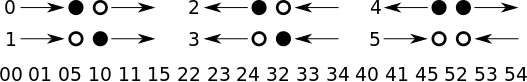

In [24]:
L=9
base,dic=build_states(L,0,0)

In [25]:
Hk=Hamiltonian(1,0,L,base,dic,bc='pbc')
Hm=mass_term(1,L,base)

In [26]:
sparse_matrix = csr_matrix(Hk)
w, v = eigsh(sparse_matrix, k=1, which='SA')
gsm0=v[:,0]

In [7]:
sparse_matrix = csr_matrix(Hk+.9*Hm)
w, v = eigsh(sparse_matrix, k=1, which='SA')
gsm09=v[:,0]

In [8]:
sparse_matrix = csr_matrix(Hk+Hm)
w, v = eigsh(sparse_matrix, k=1, which='SA')
gsm1=v[:,0]

In [9]:
creation_dic={}
for i in range(L):
    for j in range(i+1,L):
        creation_dic[i,j]=creat_pair_pm(i,j,base,dic)

In [10]:
xx=[(x+L//2)%L for x in range(1,L,1)]
yy0=[dot(conjugate(gsm0),dot(creation_dic[0,i],gsm0)) for i in range(1,L,1)]
yy09=[dot(conjugate(gsm09),dot(creation_dic[0,i],gsm09)) for i in range(1,L,1)]
yy1=[dot(conjugate(gsm1),dot(creation_dic[0,i],gsm1)) for i in range(1,L,1)]

<IPython.core.display.Javascript object>


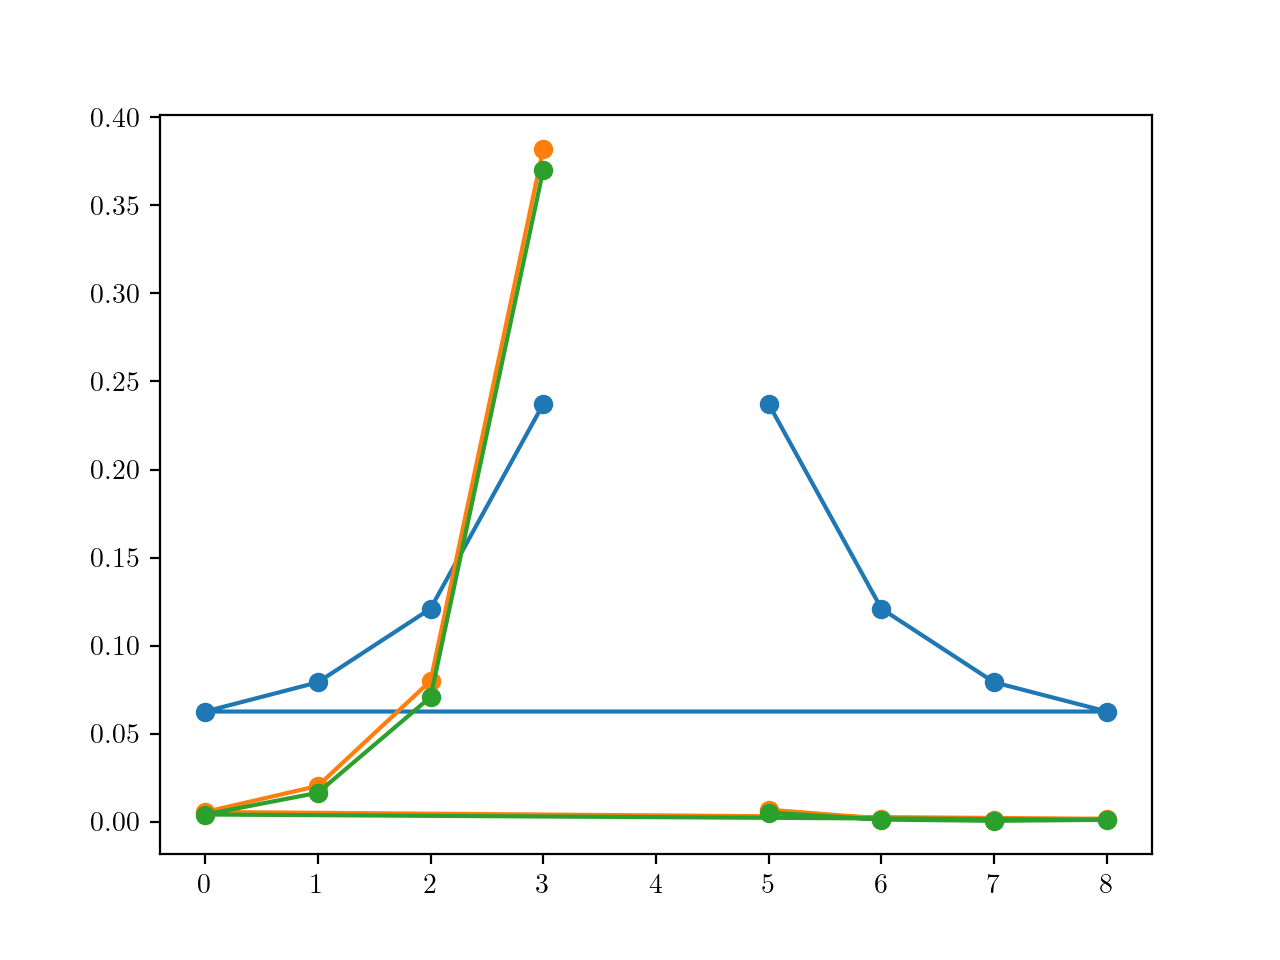

In [11]:
plot(xx,yy0,'o-')
plot(xx,yy09,'o-')
plot(xx,yy1,'o-')

In [12]:
yys10=[dot(conjugate(gsm1),dot(creation_dic[0,i],gsm0))/dot(conjugate(gsm1),gsm0) for i in range(1,L,1)]
yys109=[dot(conjugate(gsm1),dot(creation_dic[0,i],gsm09))/dot(conjugate(gsm1),gsm09) for i in range(1,L,1)]
yys009=[dot(conjugate(gsm09),dot(creation_dic[0,i],gsm0))/dot(conjugate(gsm09),gsm0) for i in range(1,L,1)]

<IPython.core.display.Javascript object>


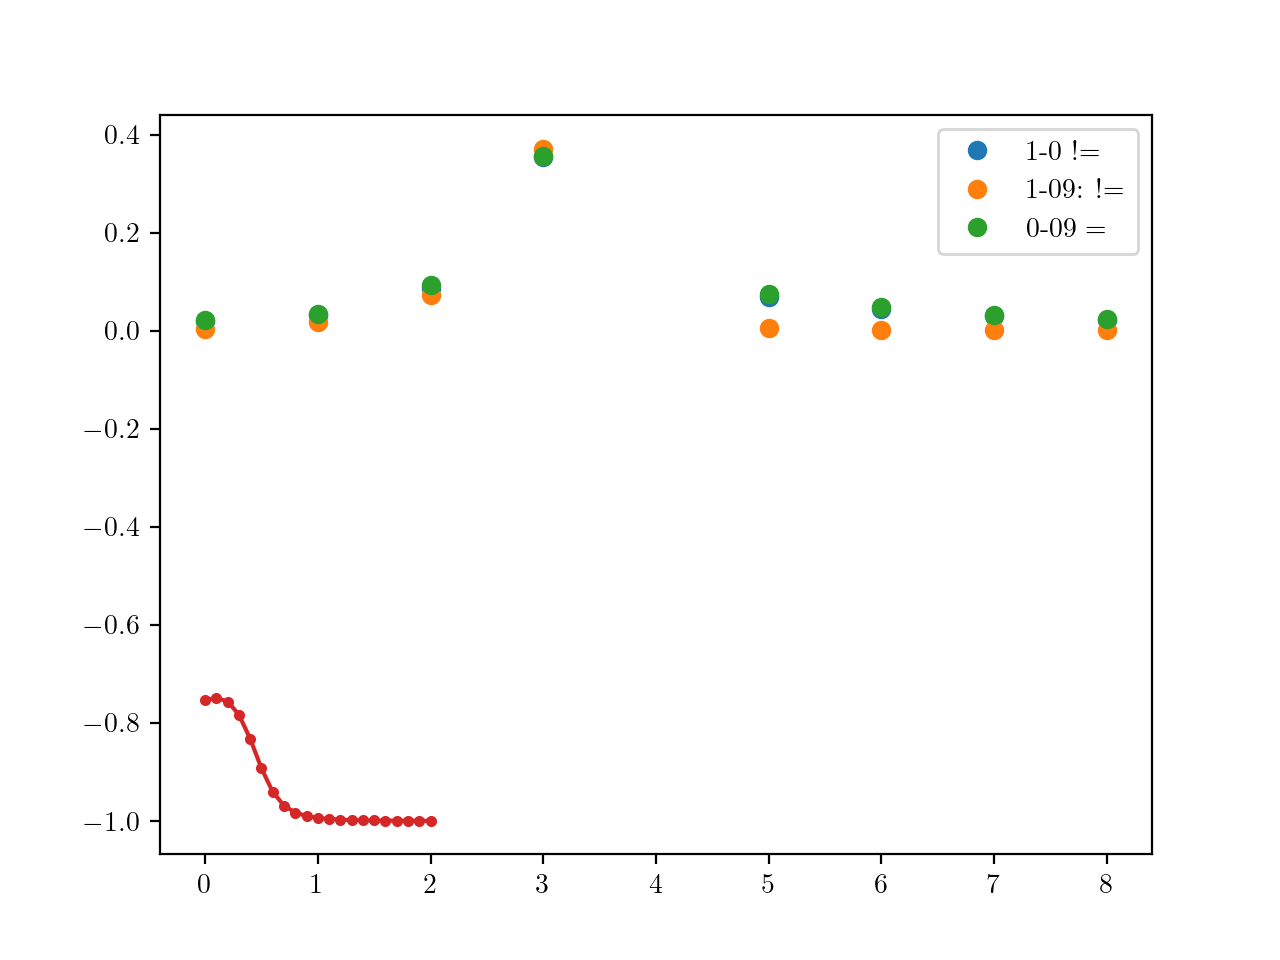

In [14]:
plot(xx,yys10,'o',label='1-0 !=')
plot(xx,yys109,'o',label='1-09: !=')
plot(xx,yys009,'o',label='0-09 =')
legend(loc=0)

## Explorations with Small System Sizes

In [15]:
marr=array(arange(.0,2.1,.1))
Llst=[2,3,4,5,6]
L_dic={}
for L in Llst:
    bare_vacuum_states=[zeros(L,int)+3,zeros(L,int)+1]
    L_dic[L]={}
    for bc in [[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]:
        bc_str=''.join(map(str,bc))
        base,dic=build_states(L,*bc)
        b=''
        if bc[0]==0:
            b='pbc'
        Hk=Hamiltonian(1,0,L,base,dic,bc=b)
        Hm=mass_term(1,L,base)
        E=Efield(base)
        L_dic[L][bc_str]={}
        L_dic[L][bc_str]['gs0']=[]
        L_dic[L][bc_str]['gs1']=[]
        L_dic[L][bc_str]['El0']=[]
        L_dic[L][bc_str]['El1']=[]
        L_dic[L][bc_str]['En0']=[]
        L_dic[L][bc_str]['En1']=[]
        L_dic[L][bc_str]['chd0']=[]
        L_dic[L][bc_str]['chd1']=[]
        L_dic[L][bc_str]['bv']=zeros(len(Hk))
        if sum(bc)!=0:
            M=st_2_M(bare_vacuum_states[(bc[0]+1)//2])
            L_dic[L][bc_str]['bv'][dic[M]]=1
        elif bc==[0,0]:
            M1=st_2_M(bare_vacuum_states[0])
            M2=st_2_M(bare_vacuum_states[1])
            L_dic[L][bc_str]['bv'][dic[M1]]=1/sqrt(2)
            L_dic[L][bc_str]['bv'][dic[M2]]=1/sqrt(2)
        for m in marr:
            sparse_matrix = csr_matrix(Hk+m*Hm)
            w, v = eigsh(sparse_matrix, k=2, which='SA')
            #w,v=eigh(Hk+m*Hm)
            for i in range(2):
                L_dic[L][bc_str]['En'+str(i)]+=[w[i]]
                L_dic[L][bc_str]['gs'+str(i)]+=[v[:,i]]
                vprime=dot(E,v[:,i])
                L_dic[L][bc_str]['El'+str(i)]+=[dot(conjugate(v[:,i]),vprime)/(L+1)]
                lst=[]
                for x in range(L):
                    vprime=dot(charge_at_x(x,base),v[:,i])
                    lst+=[dot(conjugate(v[:,i]),vprime)/(L+1)]
                L_dic[L][bc_str]['chd'+str(i)]+=[lst]
    print(L)

2
3
4
5
6


<IPython.core.display.Javascript object>


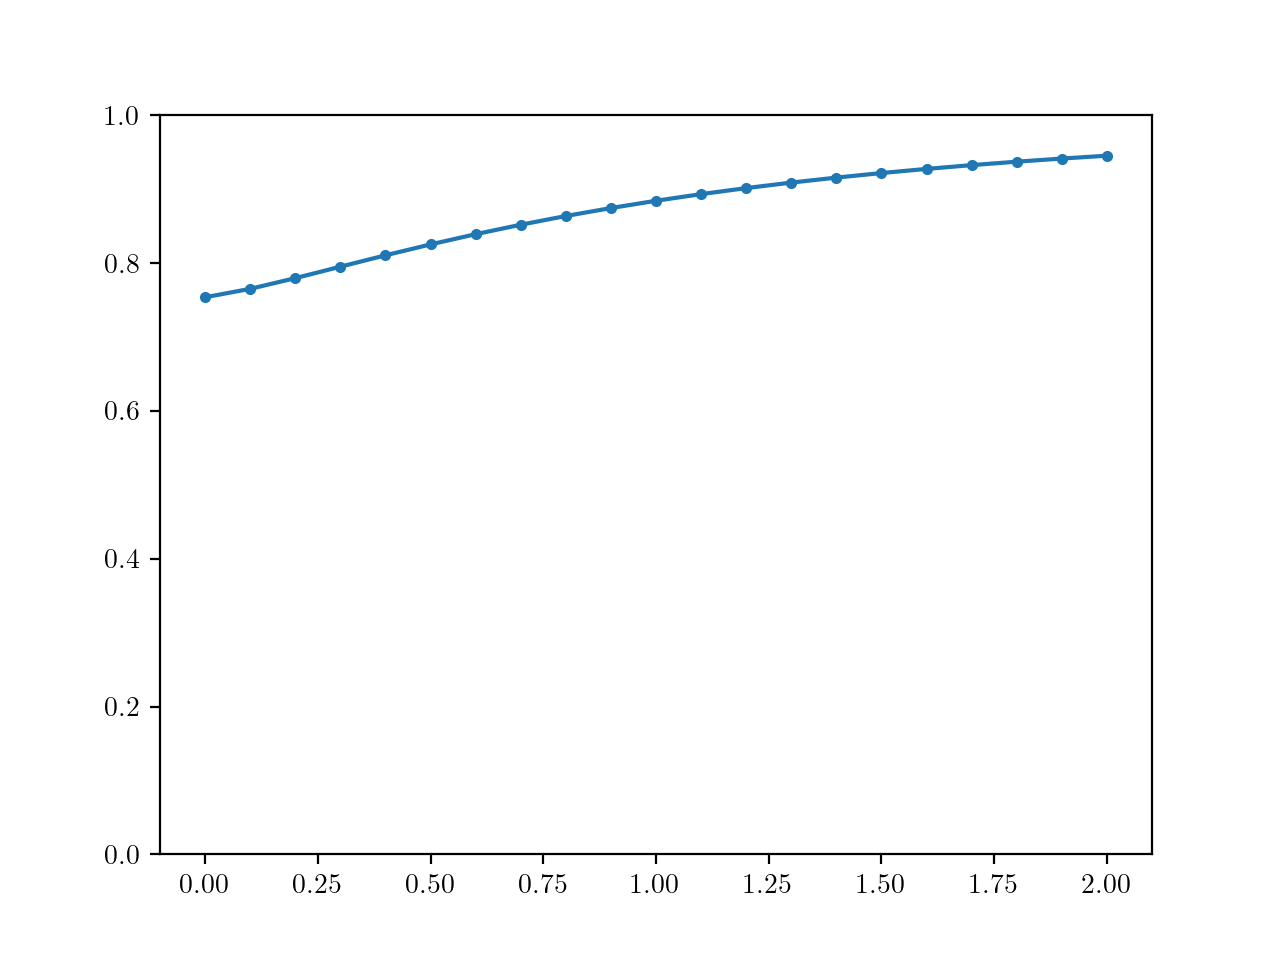

(0.0, 1.0)

In [23]:
plot(marr,array(L_dic[5][''.join(map(str,[1,1]))]['El0']),'.-')
ylim(0,1)

### Varying the Mass for $L=6$

<IPython.core.display.Javascript object>


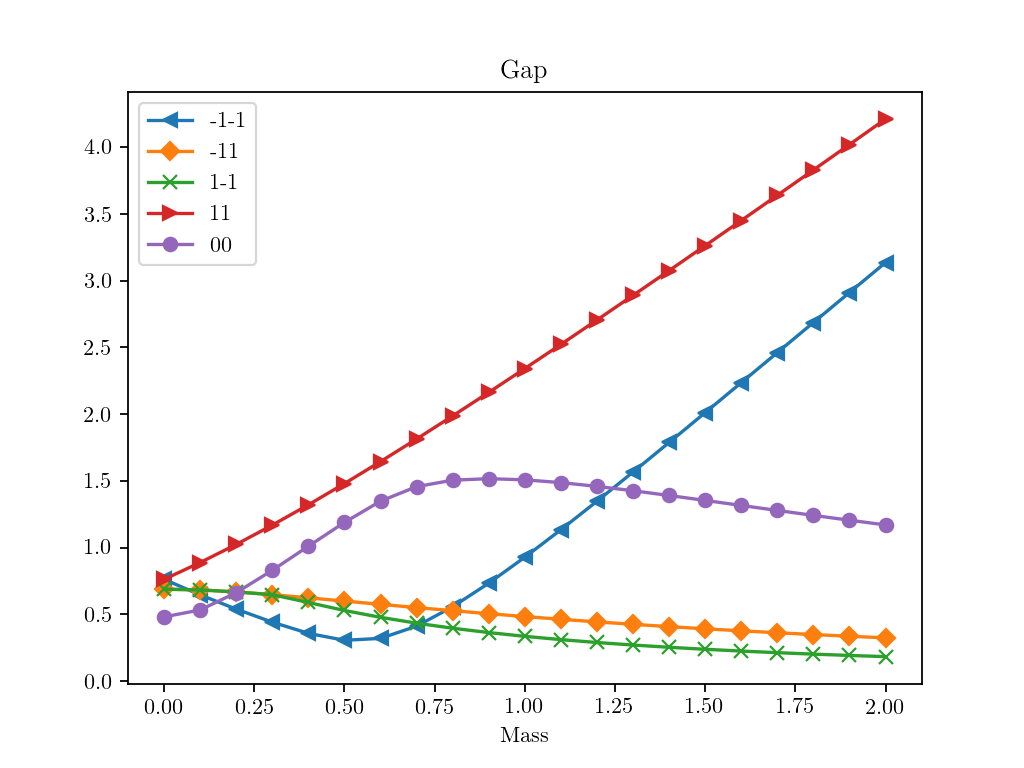

In [15]:
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(marr,array(L_dic[6][bc_str]['En1'])-array(L_dic[6][bc_str]['En0']),mks[i]+'-',label=bc_str)
title('Gap')
xlabel('Mass')
legend(loc=0)

<IPython.core.display.Javascript object>


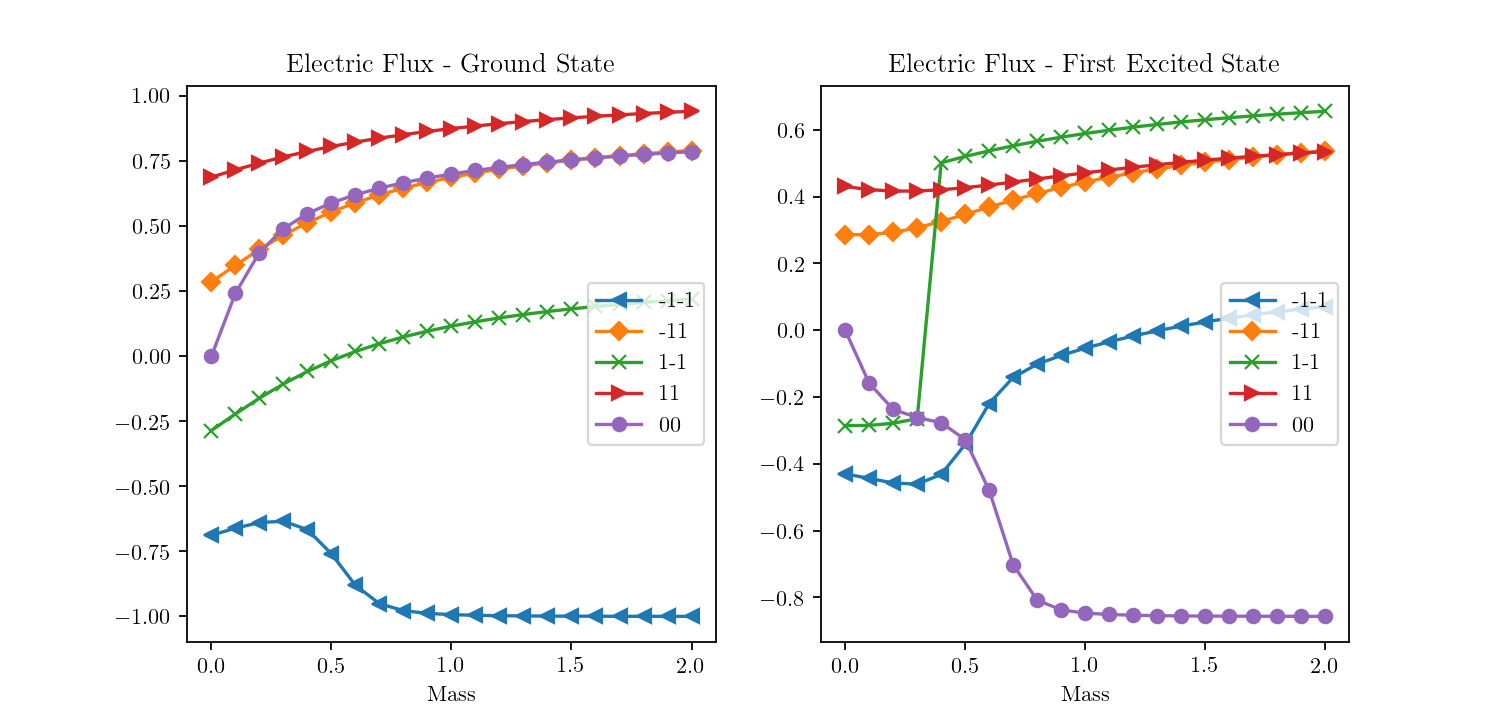

In [17]:
subplot(1, 2, 1)
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(marr,array(L_dic[6][bc_str]['El0']),mks[i]+'-',label=bc_str)
title('Electric Flux - Ground State')
xlabel('Mass')
legend(loc=7)

subplot(1, 2, 2)
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(marr,array(L_dic[6][bc_str]['El1']),mks[i]+'-',label=bc_str)
title('Electric Flux - First Excited State')
xlabel('Mass')
legend(loc=7)

<IPython.core.display.Javascript object>


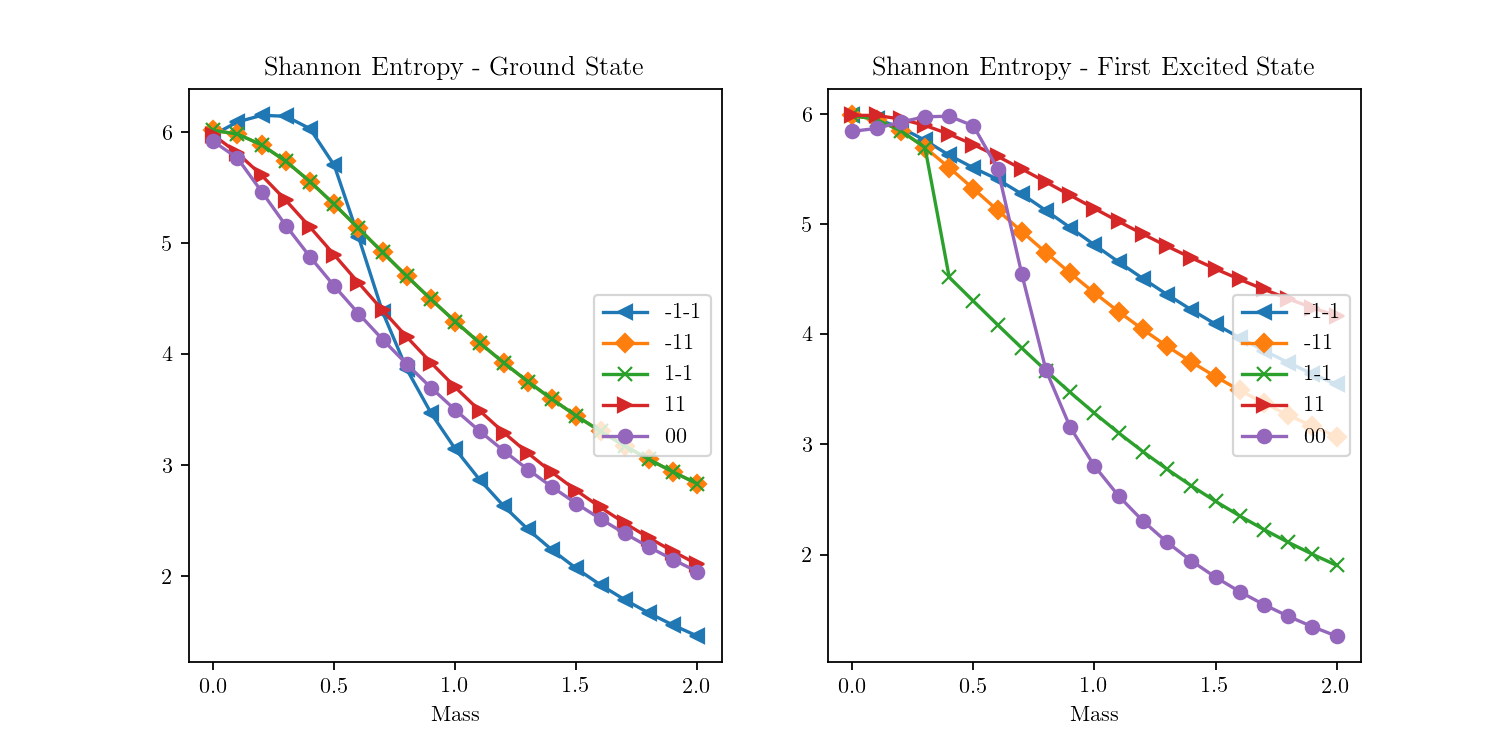

In [18]:
mks=['<','D','x','>','o']
subplot(1, 2, 1)
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    sh=[]
    for j,m in enumerate(marr):
        sh+=[shannon_st(L_dic[6][bc_str]['gs0'][j])]
    plot(marr,sh,mks[i]+'-',label=bc_str)
title('Shannon Entropy - Ground State')
xlabel('Mass')
legend(loc=7)

subplot(1, 2, 2)
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    sh=[]
    for j,m in enumerate(marr):
        sh+=[shannon_st(L_dic[6][bc_str]['gs1'][j])]
    plot(marr,sh,mks[i]+'-',label=bc_str)
title('Shannon Entropy - First Excited State')
xlabel('Mass')
legend(loc=7)

<IPython.core.display.Javascript object>


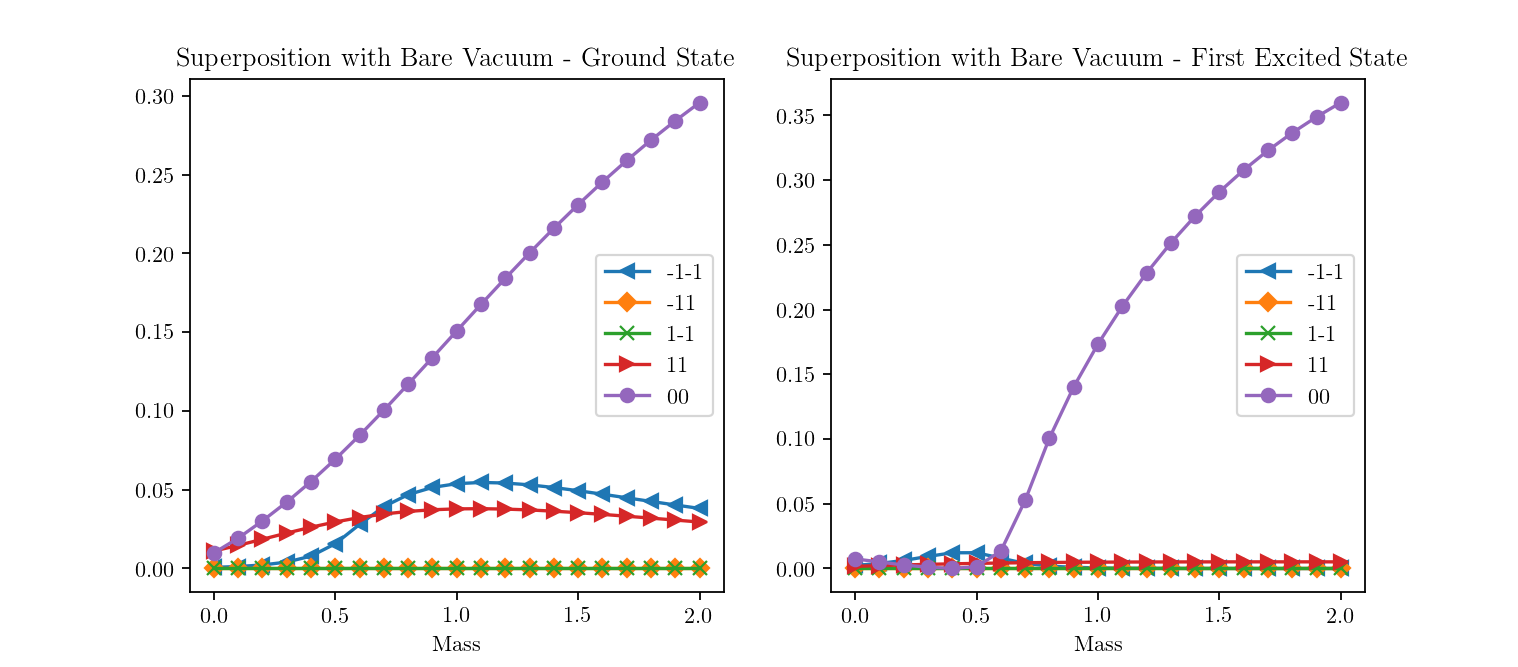

In [19]:
mks=['<','D','x','>','o']

subplot(1, 2, 1)
bv_states=[zeros(6)+3,zeros(6),zeros(6),zeros(6)+1,]
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    sup=[]
    for j,m in enumerate(marr):
        sup+=[abs(dot(L_dic[6][bc_str]['bv'],L_dic[6][bc_str]['gs0'][j]))**2]
    plot(marr,sup,mks[i]+'-',label=bc_str)
title('Superposition with Bare Vacuum - Ground State')
xlabel('Mass')
legend(loc=7)

subplot(1, 2, 2)
bv_states=[zeros(6)+3,zeros(6),zeros(6),zeros(6)+1,]
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    sup=[]
    for j,m in enumerate(marr):
        sup+=[abs(dot(L_dic[6][bc_str]['bv'],L_dic[6][bc_str]['gs1'][j]))**2]
    plot(marr,sup,mks[i]+'-',label=bc_str)
title('Superposition with Bare Vacuum - First Excited State')
xlabel('Mass')
legend(loc=7)

### Some Charge Profiles for $L=6$

<IPython.core.display.Javascript object>


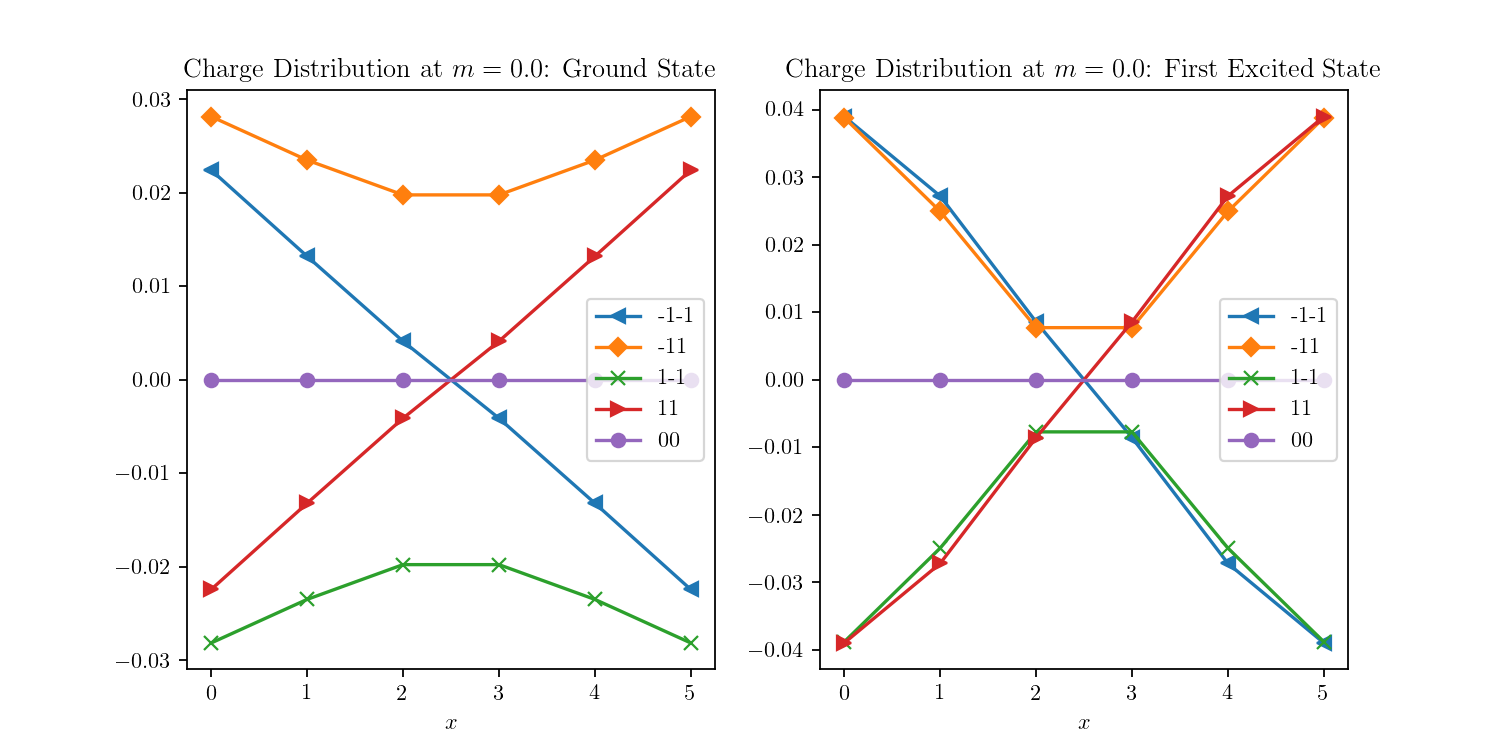

In [26]:
mass=0

subplot(1, 2, 1)
for jm,m in enumerate(marr):
    if abs(m-mass)<.000000001:
        break
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(range(6),L_dic[6][bc_str]['chd0'][jm],mks[i]+'-',label=bc_str)
title(r'Charge Distribution at $m={}$: Ground State'.format(m))
xlabel('$x$')
legend(loc=7)

subplot(1, 2, 2)
for jm,m in enumerate(marr):
    if abs(m-mass)<.000000001:
        break
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(range(6),L_dic[6][bc_str]['chd1'][jm],mks[i]+'-',label=bc_str)
title(r'Charge Distribution at $m={}$: First Excited State'.format(m))
xlabel('$x$')
legend(loc=7)

<IPython.core.display.Javascript object>


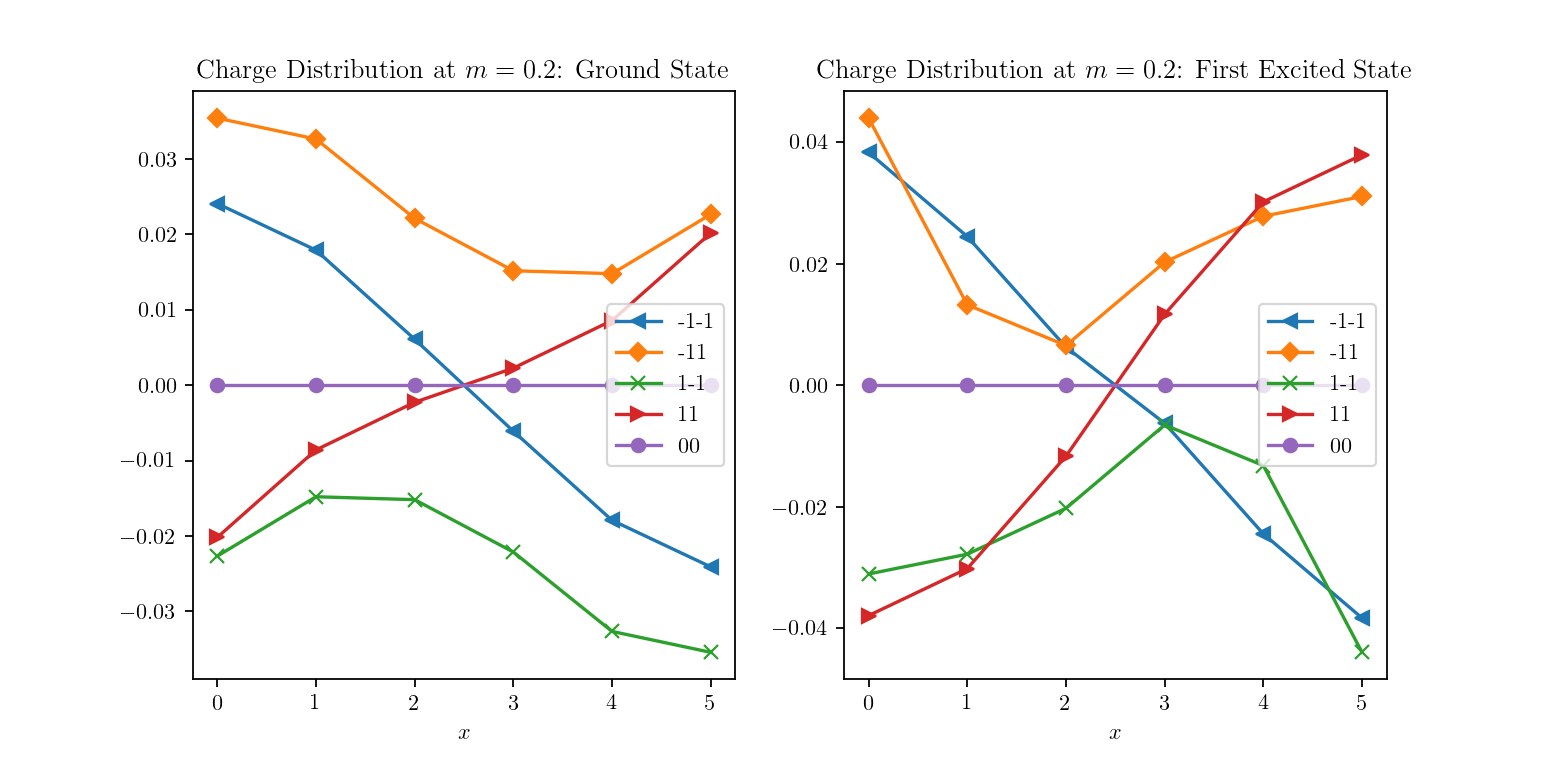

In [25]:
mass=0.2

subplot(1, 2, 1)
for jm,m in enumerate(marr):
    if abs(m-mass)<.000000001:
        break
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(range(6),L_dic[6][bc_str]['chd0'][jm],mks[i]+'-',label=bc_str)
title(r'Charge Distribution at $m={}$: Ground State'.format(m))
xlabel('$x$')
legend(loc=7)

subplot(1, 2, 2)
for jm,m in enumerate(marr):
    if abs(m-mass)<.000000001:
        break
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(range(6),L_dic[6][bc_str]['chd1'][jm],mks[i]+'-',label=bc_str)
title(r'Charge Distribution at $m={}$: First Excited State'.format(m))
xlabel('$x$')
legend(loc=7)

<IPython.core.display.Javascript object>


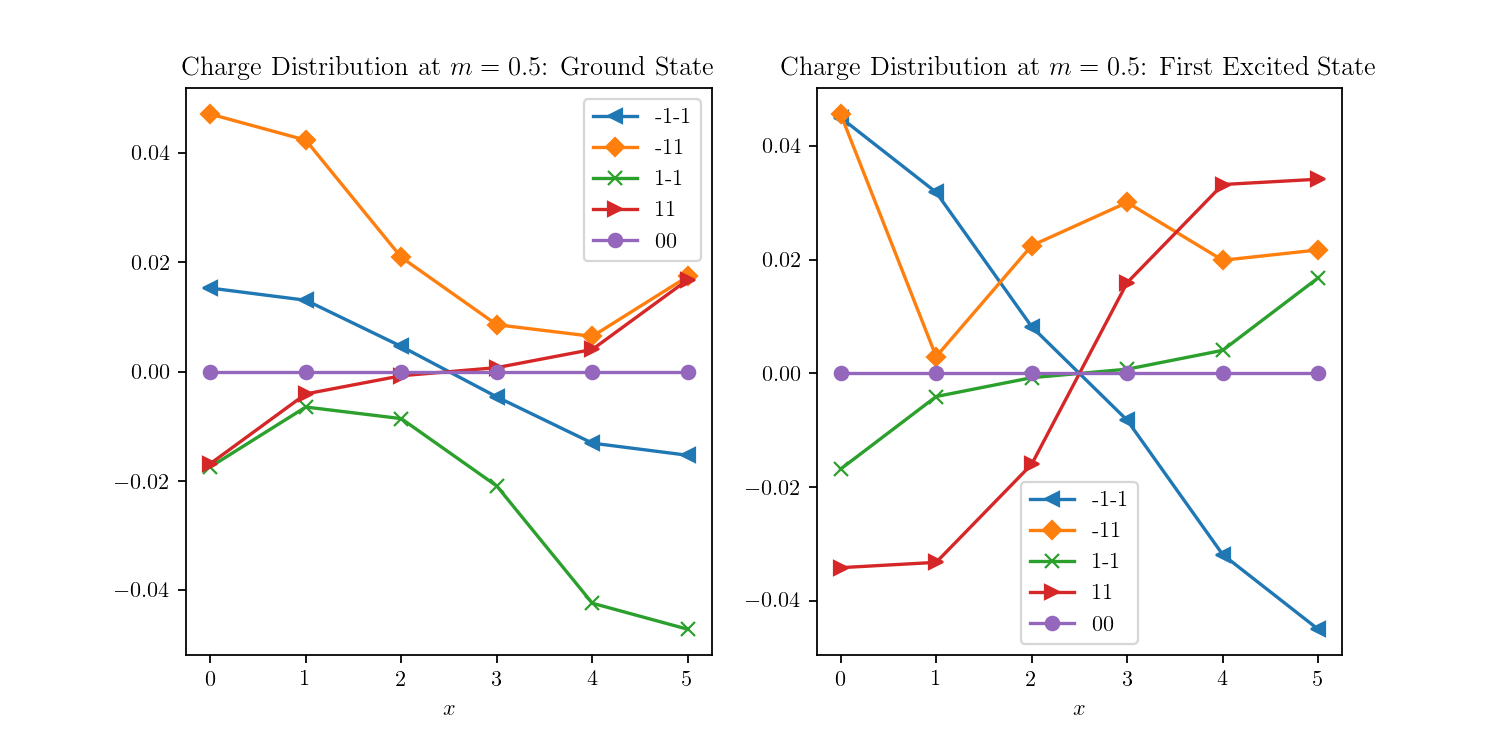

In [24]:
mass=0.5

subplot(1, 2, 1)
for jm,m in enumerate(marr):
    if abs(m-mass)<.000000001:
        break
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(range(6),L_dic[6][bc_str]['chd0'][jm],mks[i]+'-',label=bc_str)
title(r'Charge Distribution at $m={}$: Ground State'.format(m))
xlabel('$x$')
legend(loc=0)

subplot(1, 2, 2)
for jm,m in enumerate(marr):
    if abs(m-mass)<.000000001:
        break
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(range(6),L_dic[6][bc_str]['chd1'][jm],mks[i]+'-',label=bc_str)
title(r'Charge Distribution at $m={}$: First Excited State'.format(m))
xlabel('$x$')
legend(loc=0)

<IPython.core.display.Javascript object>


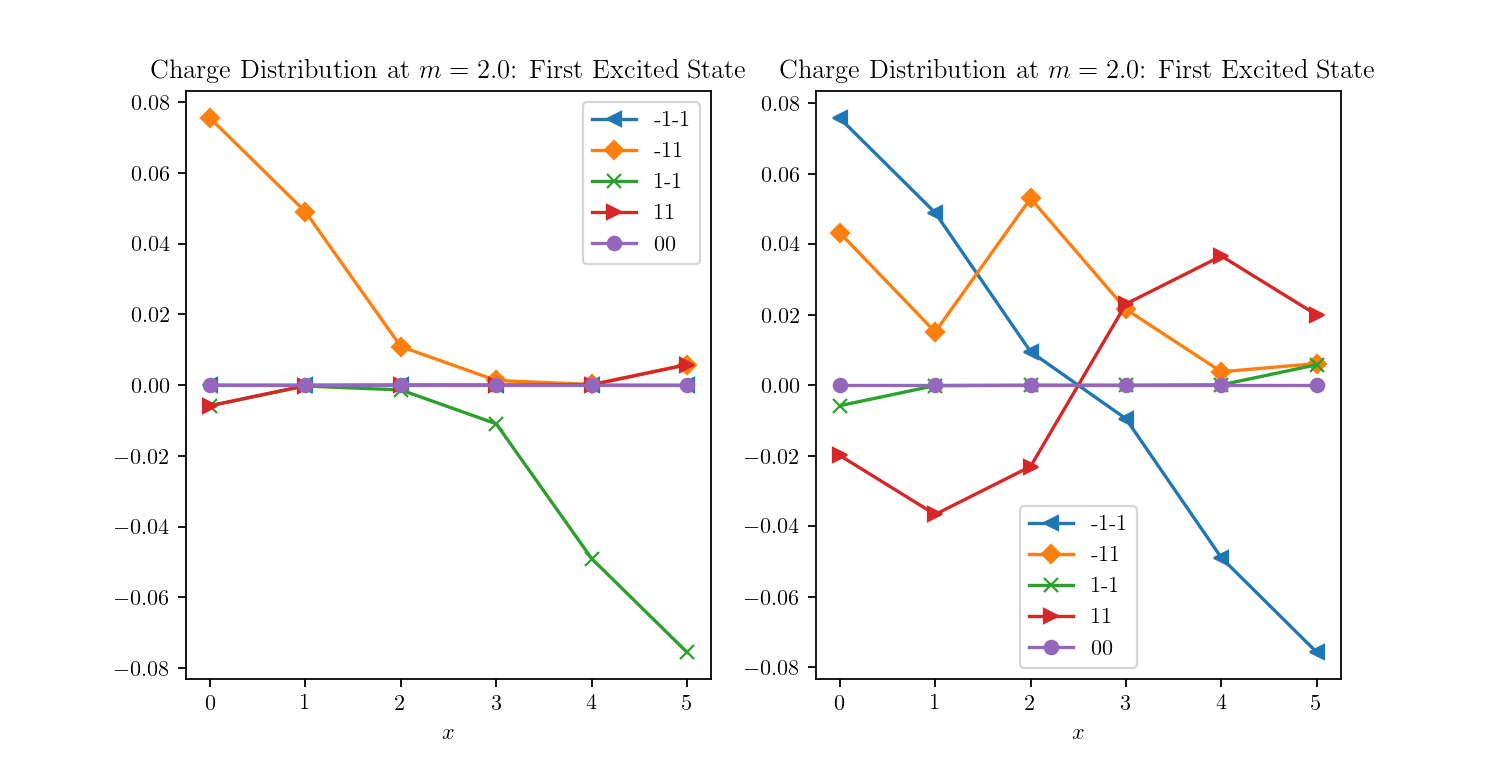

In [27]:
mass=2.0

subplot(1, 2, 1)
for jm,m in enumerate(marr):
    if abs(m-mass)<.000000001:
        break
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(range(6),L_dic[6][bc_str]['chd0'][jm],mks[i]+'-',label=bc_str)
title(r'Charge Distribution at $m={}$: First Excited State'.format(m))
xlabel('$x$')
legend(loc=0)

subplot(1, 2, 2)
for jm,m in enumerate(marr):
    if abs(m-mass)<.000000001:
        break
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(range(6),L_dic[6][bc_str]['chd1'][jm],mks[i]+'-',label=bc_str)
title(r'Charge Distribution at $m={}$: First Excited State'.format(m))
xlabel('$x$')
legend(loc=0)

In [5]:
marr=array(arange(.0,2.1,.2))
Llst=[8]
L_dic={}
for L in Llst:
    bare_vacuum_states=[zeros(L,int)+3,zeros(L,int)+1]
    L_dic[L]={}
    for bc in [[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]:
        bc_str=''.join(map(str,bc))
        base,dic=build_states(L,*bc)
        b=''
        if bc[0]==0:
            b='pbc'
        Hk=Hamiltonian(1,0,L,base,dic,bc=b)
        Hm=mass_term(1,L,base)
        E=Efield(base)
        L_dic[L][bc_str]={}
        L_dic[L][bc_str]['gs0']=[]
        L_dic[L][bc_str]['gs1']=[]
        L_dic[L][bc_str]['El0']=[]
        L_dic[L][bc_str]['El1']=[]
        L_dic[L][bc_str]['En0']=[]
        L_dic[L][bc_str]['En1']=[]
        L_dic[L][bc_str]['bv']=zeros(len(Hk))
        if sum(bc)!=0:
            M=st_2_M(bare_vacuum_states[(bc[0]+1)//2])
            L_dic[L][bc_str]['bv'][dic[M]]=1
        elif bc==[0,0]:
            M1=st_2_M(bare_vacuum_states[0])
            M2=st_2_M(bare_vacuum_states[1])
            L_dic[L][bc_str]['bv'][dic[M1]]=1/sqrt(2)
            L_dic[L][bc_str]['bv'][dic[M2]]=1/sqrt(2)
        for m in marr:
            sparse_matrix = csr_matrix(Hk+m*Hm)
            w, v = eigsh(sparse_matrix, k=2, which='SA')
            #w,v=eigh(Hk+m*Hm)
            for i in range(2):
                L_dic[L][bc_str]['En'+str(i)]+=[w[i]]
                L_dic[L][bc_str]['gs'+str(i)]+=[v[:,i]]
                vprime=dot(E,v[:,i])
                L_dic[L][bc_str]['El'+str(i)]+=[dot(conjugate(v[:,i]),vprime)/(L+1)]
    print(L)

8


<IPython.core.display.Javascript object>


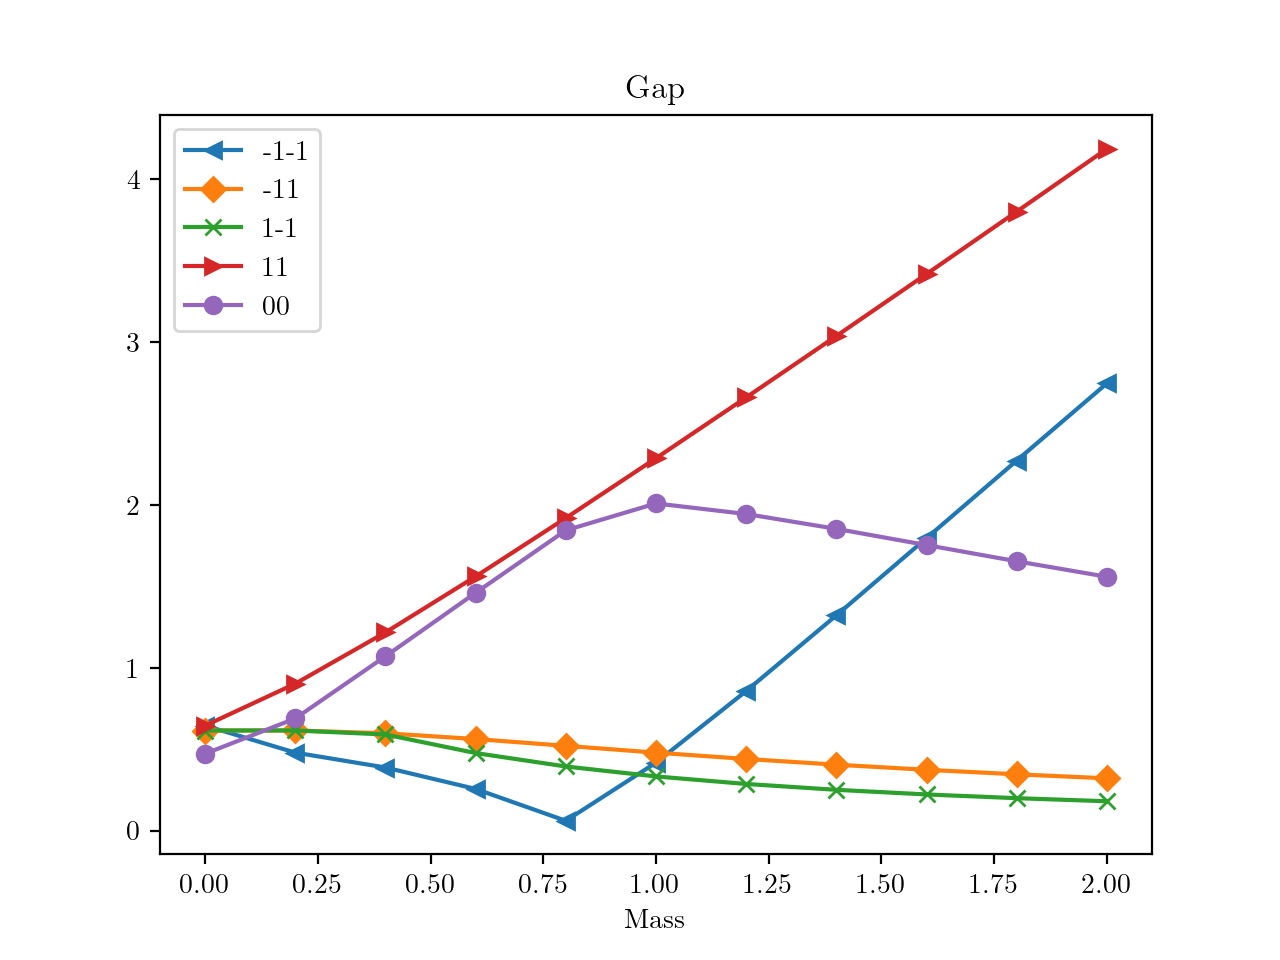

In [6]:
L=8
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(marr,array(L_dic[L][bc_str]['En1'])-array(L_dic[L][bc_str]['En0']),mks[i]+'-',label=bc_str)
title('Gap')
xlabel('Mass')
legend(loc=0)

In [10]:
marr=array(arange(.9,1.1,0.01))
Llst=[9]
L_dic={}
for L in Llst:
    bare_vacuum_states=[zeros(L,int)+3,zeros(L,int)+1]
    L_dic[L]={}
    for bc in [[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]:
        bc_str=''.join(map(str,bc))
        base,dic=build_states(L,*bc)
        b=''
        if bc[0]==0:
            b='pbc'
        Hk=Hamiltonian(1,0,L,base,dic,bc=b)
        Hm=mass_term(1,L,base)
        E=Efield(base)
        L_dic[L][bc_str]={}
        L_dic[L][bc_str]['gs0']=[]
        L_dic[L][bc_str]['gs1']=[]
        L_dic[L][bc_str]['El0']=[]
        L_dic[L][bc_str]['El1']=[]
        L_dic[L][bc_str]['En0']=[]
        L_dic[L][bc_str]['En1']=[]
        L_dic[L][bc_str]['bv']=zeros(len(Hk))
        if sum(bc)!=0:
            M=st_2_M(bare_vacuum_states[(bc[0]+1)//2])
            L_dic[L][bc_str]['bv'][dic[M]]=1
        elif bc==[0,0]:
            M1=st_2_M(bare_vacuum_states[0])
            M2=st_2_M(bare_vacuum_states[1])
            L_dic[L][bc_str]['bv'][dic[M1]]=1/sqrt(2)
            L_dic[L][bc_str]['bv'][dic[M2]]=1/sqrt(2)
        for m in marr:
            sparse_matrix = csr_matrix(Hk+m*Hm)
            w, v = eigsh(sparse_matrix, k=2, which='SA')
            #w,v=eigh(Hk+m*Hm)
            for i in range(2):
                L_dic[L][bc_str]['En'+str(i)]+=[w[i]]
                L_dic[L][bc_str]['gs'+str(i)]+=[v[:,i]]
                vprime=dot(E,v[:,i])
                L_dic[L][bc_str]['El'+str(i)]+=[dot(conjugate(v[:,i]),vprime)/(L+1)]
    print(L)

9


In [11]:
with open('L9.pkl', 'wb') as file:
    pickle.dump(L_dic, file)

In [2]:
with open('L9.pkl', 'rb') as file:
    L_dic = pickle.load(file)

<IPython.core.display.Javascript object>


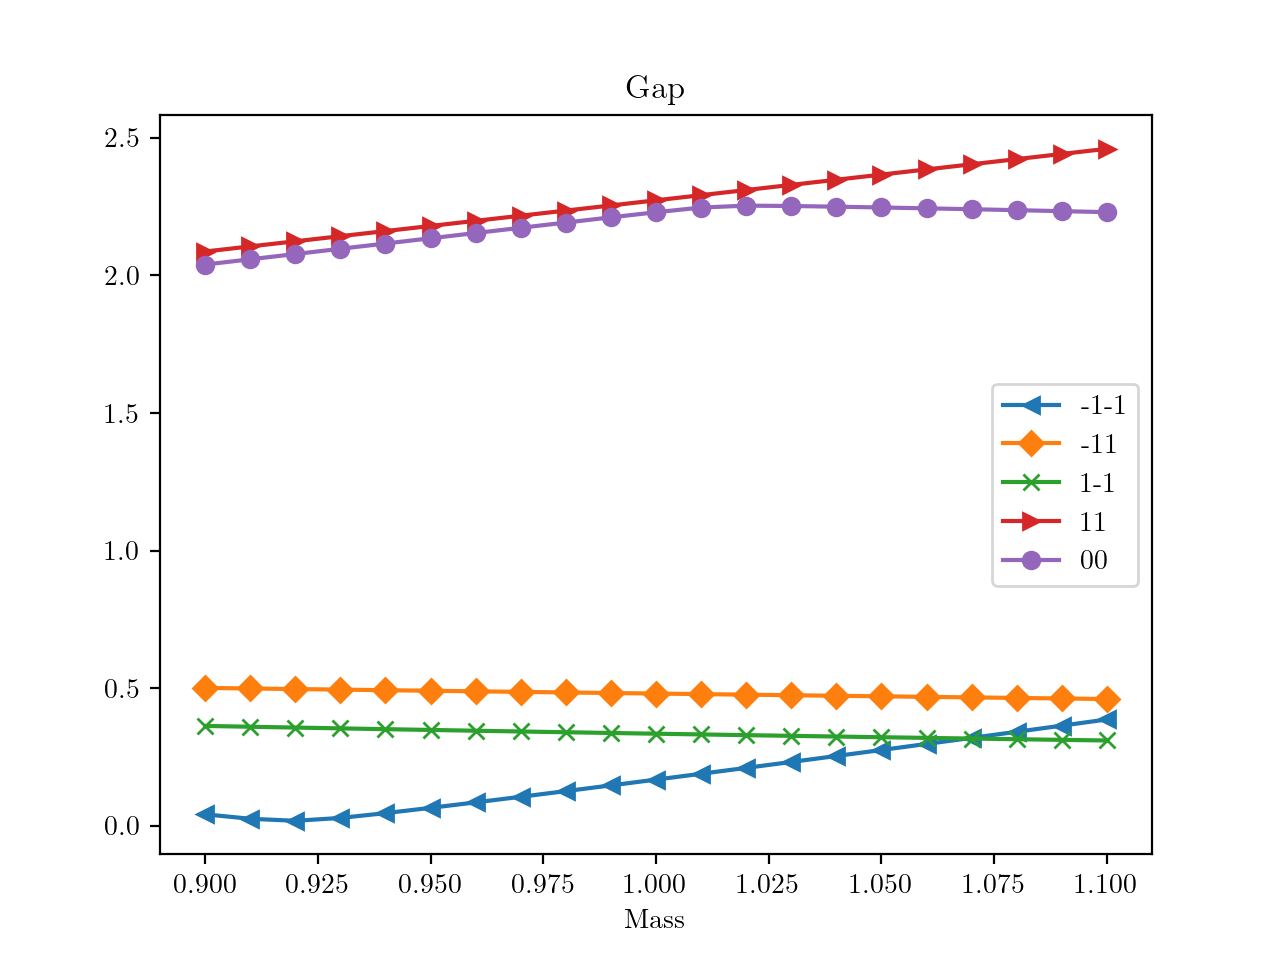

In [12]:
L=9
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(marr,array(L_dic[L][bc_str]['En1'])-array(L_dic[L][bc_str]['En0']),mks[i]+'-',label=bc_str)
title('Gap')
xlabel('Mass')
legend(loc=0)

<IPython.core.display.Javascript object>


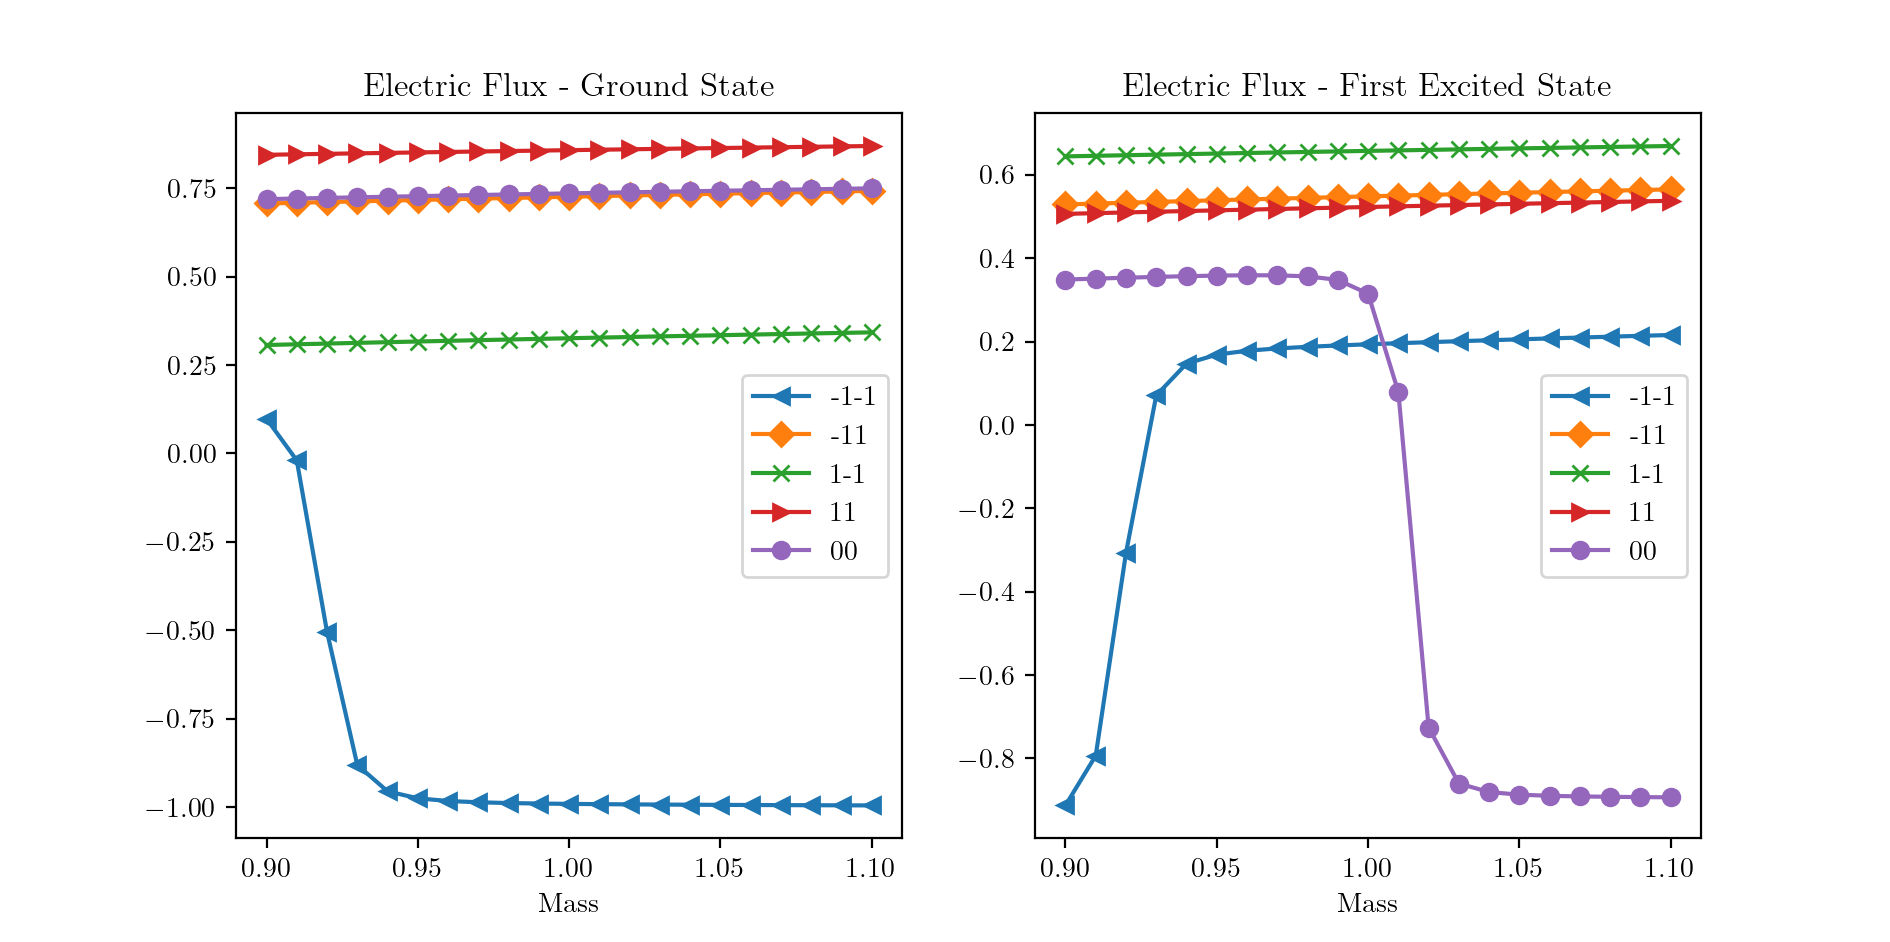

In [15]:
L=9
subplot(1, 2, 1)
mks=['<','D','x','>','o']
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(marr,array(L_dic[L][bc_str]['El0']),mks[i]+'-',label=bc_str)
title('Electric Flux - Ground State')
xlabel('Mass')
legend(loc=7)

subplot(1, 2, 2)
for i,bc in enumerate([[-1,-1],[-1,1],[1,-1],[1,1],[0,0]]):
    bc_str=''.join(map(str,bc))
    plot(marr,array(L_dic[L][bc_str]['El1']),mks[i]+'-',label=bc_str)
title('Electric Flux - First Excited State')
xlabel('Mass')
legend(loc=7)

In [ ]:
Hamiltonian(1,0,9,base,dic,bc='pbc')

<IPython.core.display.Javascript object>


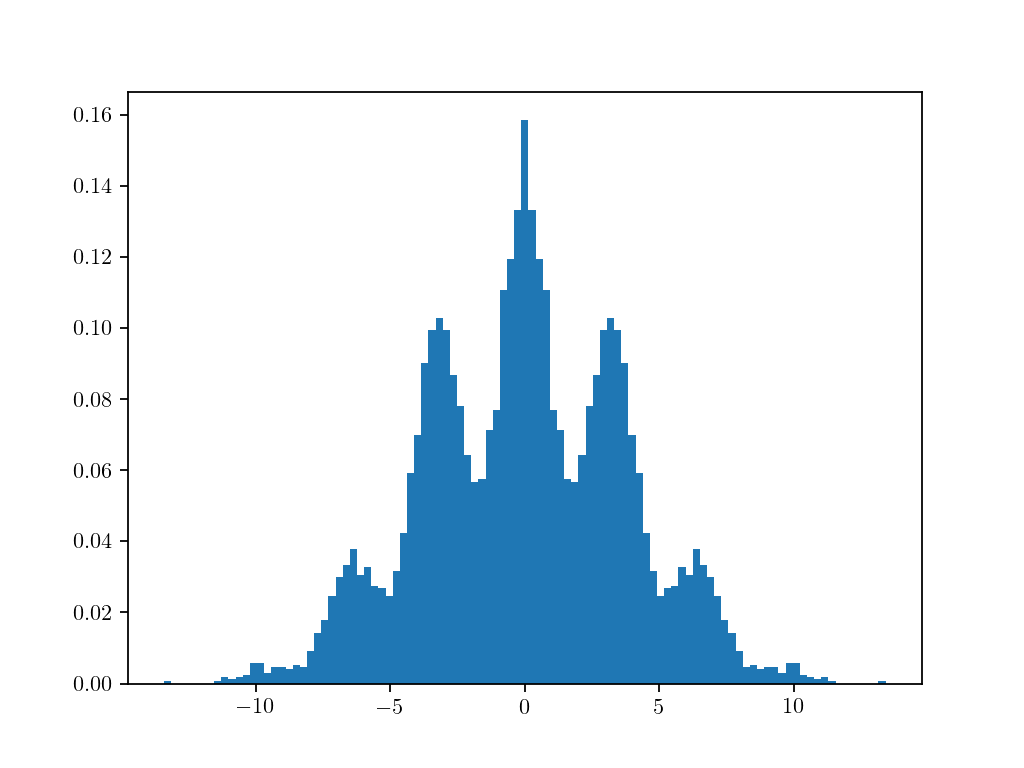

(array([0.00057434, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00057434, 0.00172302, 0.00114868,
        0.00172302, 0.00229736, 0.0057434 , 0.0057434 , 0.0028717 ,
        0.00459472, 0.00459472, 0.00402038, 0.00516906, 0.00459472,
        0.00918945, 0.01435851, 0.01780455, 0.02469664, 0.0298657 ,
        0.03331174, 0.03790646, 0.03044004, 0.0327374 , 0.02756834,
        0.026994  , 0.02469664, 0.03158872, 0.04250119, 0.05915706,
        0.07006952, 0.09017144, 0.09936088, 0.10280692, 0.09936088,
        0.08672539, 0.07811029, 0.06432612, 0.0568597 , 0.05743404,
        0.0712182 , 0.07696161, 0.11084769, 0.11946279, 0.13324696,
        0.15851794, 0.13324696, 0.11946279, 0.11084769, 0.07696161,
        0.0712182 , 0.05743404, 0.0568597 , 0.06432612, 0.07811029,
        0.08672539, 0.09936088, 0.10280692, 0.09936088, 0.09017144,
        0.07006952, 0.05915706, 0.04250119, 0.03158872, 0.02469664,
        0.026994  , 0.02756834, 0.0327374 , 0.03

In [55]:
hist(w,bins=101,density=True)

In [57]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


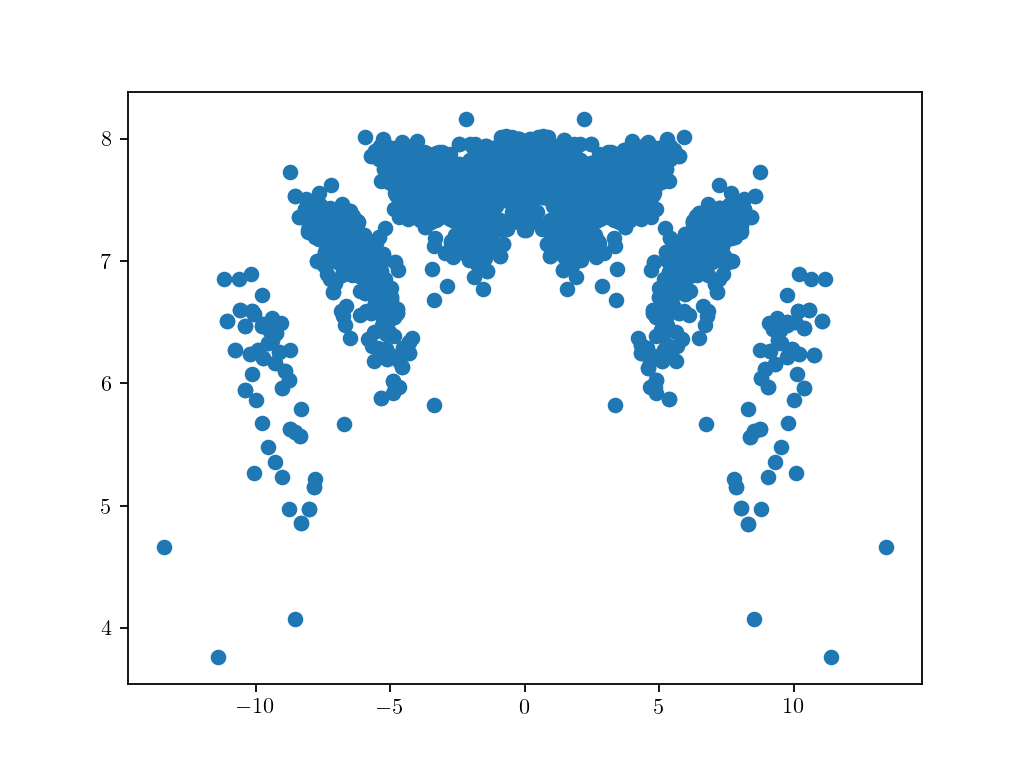

In [59]:
plot(w,sh,'o')

In [2]:
def Hamiltonian(t,m,L):
    N=2**L
    H=zeros((N,N))
    for i in range(N):
        st=bin(i)[2:]
        st='0'*(N-len(st))+st
        for n,o in enumerate(st[:-1]):
            H[i,i]+=m*int(o)*(-1)**n
            if st[n+1]=='0' and st[n]=='1':
                newst=st[:n]+'01'+st[n+2:]
                j=int(newst,2)
                H[i,j]=-t
                H[j,i]=-t
        H[i,i]+=m*int(st[-1])*(-1)**(L-1)
    return H

<IPython.core.display.Javascript object>


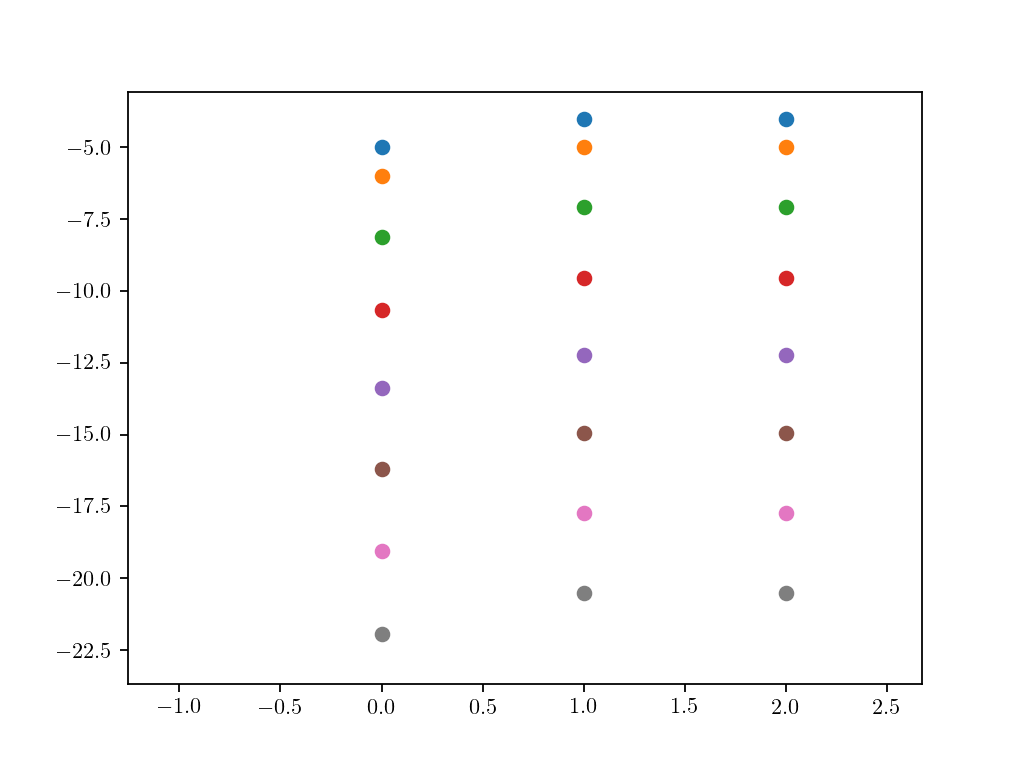

In [4]:
for t in arange(.0,4.,.5):
    H=Hamiltonian(t,1,10)
    w,v=eigh(H)
    plot(range(len(w)),w,'o')

In [14]:
def HBdG(t,m,delta,L):
    H=zeros((2*L,2*L))
    for i in range(L):
        H[i,i]=((-1)**i)*m/4
        H[i,i+1]=-((-1)**i)*t/2
        H[i+L,i+1]=-delta
    H[L:,:L]+=transpose(H[L:,:L])
    H[:L,L:]=-H[L:,:L]
    H[:L,:L]+=transpose(H[:L,:L])
    H[L:,L:]=H[:L,:L]
    return H

In [15]:
hbdg=HBdG(1,0,1,25)

In [16]:
w,v=eig(hbdg)

<IPython.core.display.Javascript object>


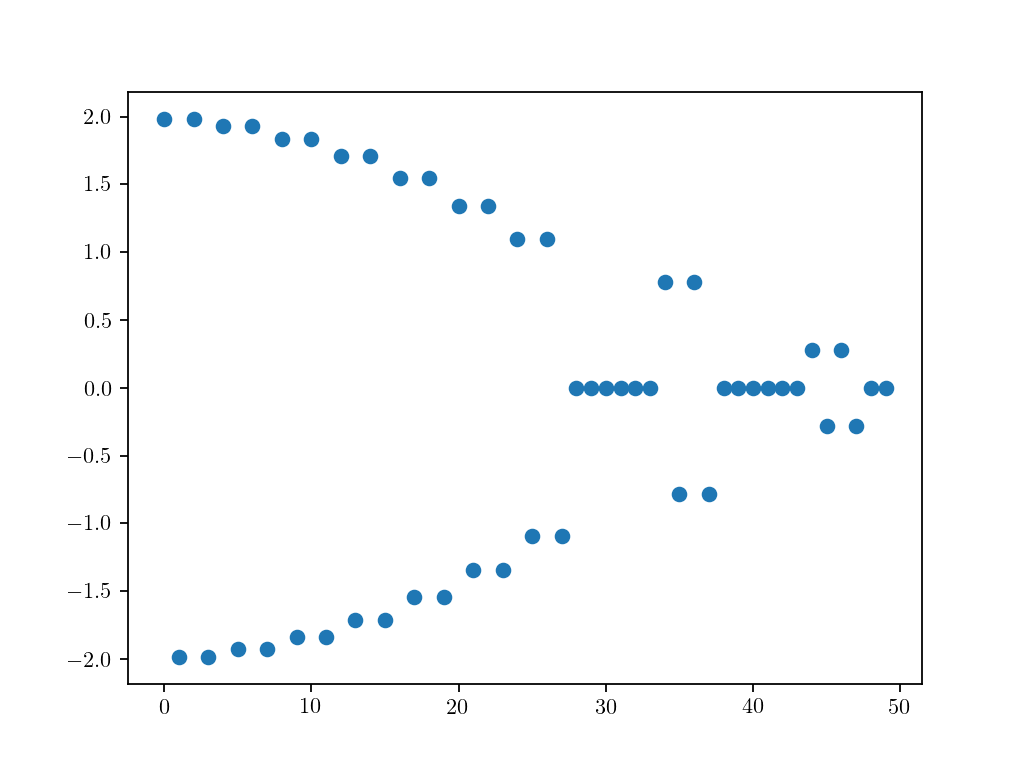

In [17]:
plot(range(len(w)),imag(w),'o')